In [2]:
import sys
import os
import numpy as np
import pandas as pd
root_dir = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
sys.path.append(root_dir)
from src.prediction.prediction import curtailment_power_prediction
from src.utils import prepare_data_for_anlagenschlüssel_df
from src.croston._predictor import CrostonForecastPredictor
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "seaborn"


/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/codespace/.python/current/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas
from gluonts.dataset import Dataset
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.mx import SimpleFeedForwardEstimator, Trainer
from gluonts.mx import DeepRenewalProcessEstimator, DeepAREstimator, SimpleFeedForwardEstimator
from gluonts.model.npts import NPTSPredictor
from gluonts.ext.prophet import ProphetPredictor
from gluonts.ext.r_forecast import RForecastPredictor
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.mx.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.mx.distribution.piecewise_linear import PiecewiseLinearOutput

In [41]:
df_ready = pd.read_csv("../data/df_ready.csv")
train_data = []
test_data = []
split_point = pd.Timestamp('2021-08-01')
for selected_Anlagenschlüssel in df_ready['Anlagenschlüssel'].unique():
    df_timeline_day = prepare_data_for_anlagenschlüssel_df(df_ready, selected_Anlagenschlüssel,freq="D")
    # Splitting the data
    train_df = df_timeline_day[df_timeline_day.index < split_point]
    test_df = df_timeline_day[df_timeline_day.index >= split_point]

    # Convert the processed DataFrame to the GluonTS format
    train_ts_dict = {'target': train_df.curtailment_power.values, 'start': train_df.index[0],'item_id': str(selected_Anlagenschlüssel)}
    test_ts_dict = {'target': test_df.curtailment_power.values, 'start': test_df.index[0], 'item_id': str(selected_Anlagenschlüssel)}

    train_data.append(train_ts_dict)
    test_data.append(test_ts_dict)

train_dataset = ListDataset(train_data, freq="D")
test_dataset = ListDataset(test_data, freq="D")

/workspaces/curtailment/src/utils.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Start'] = pd.to_datetime(df['Start'])
/workspaces/curtailment/src/utils.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ende'] = pd.to_datetime(df['Ende'])
/workspaces/curtailment/src/utils.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[128.33333333]' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

In [6]:
df_ready = pd.read_csv("../data/df_ready.csv")
split_date = pd.Timestamp("2021-08-01")
train_ds = []
test_ds = []

for selected_Anlagenschlüssel in df_ready['Anlagenschlüssel'].unique():
    df_timeline_day = prepare_data_for_anlagenschlüssel_df(df_ready, selected_Anlagenschlüssel, freq="D")

    if not df_timeline_day.empty:
        # Splitting the data
        train_df = df_timeline_day[df_timeline_day.index < split_date]
        test_df = df_timeline_day

        # Append to train_ds
        if not train_df.empty:
            train_ds.append({
                FieldName.ITEM_ID:str(selected_Anlagenschlüssel),
                FieldName.TARGET: train_df['curtailment_power'].tolist(),
                FieldName.START: train_df.index[0]
            })

        # Append to test_ds
        if not test_df.empty:
            test_ds.append({
                FieldName.ITEM_ID:str(selected_Anlagenschlüssel),
                FieldName.TARGET: test_df['curtailment_power'].tolist(),
                FieldName.START: test_df.index[0]
            })

# Convert to GluonTS ListDataset
train_dataset = ListDataset(train_ds, freq="D")
test_dataset = ListDataset(test_ds, freq="D")

/workspaces/curtailment/src/utils.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Start'] = pd.to_datetime(df['Start'])
/workspaces/curtailment/src/utils.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ende'] = pd.to_datetime(df['Ende'])
/workspaces/curtailment/src/utils.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[128.33333333]' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

In [47]:
dataset = get_dataset("m4_hourly", regenerate=False)
dataset

TrainDatasets(metadata=MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='414')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=48), train=Map(fn=<gluonts.dataset.common.ProcessDataEntry object at 0x7fa3807068f0>, iterable=JsonLinesFile(path=PosixPath('/home/codespace/.gluonts/datasets/m4_hourly/train/data.json.gz'), start=0, n=None, line_starts=[0, 4983, 10666, 16222, 21905, 27588, -32265, -25882, -19499, -13116, -8133, -1748, 4093, 9078, 14063, 20381, 25867, 32252, -26899, -21214, -15509, -9124, -4139, 846, 5879, 11564, 17949, 23634, 29319, -30532, -23789, -17145, -10595, -4910, 1475, 7160, 13545, 19230, 24915, 31656, -28195, -22510, -16825, -11140, -5706, 679, 5728, 12113, 17798, 24183, 30568, -29983, -24298, -18613, -13628, -8643, -2258, 4827, 10512, 16028, 21181, 26866, 31830, -28021, -22362, -16144, -9763, -3378, 3007, 8258, 14643, 20481, 25466, 30511, -30040, -23757, -18772, -13785, -

In [4]:
prediction_length = len(test_df.TimeSlot.unique())
freq='D'

In [7]:

ets_predictor = RForecastPredictor(freq= freq, 
                                   prediction_length= prediction_length, 
                                   method_name = 'ets', 
                                   )

ets_forecast = list(ets_predictor.predict(train_dataset))

/home/codespace/.python/current/lib/python3.10/site-packages/rpy2/rinterface.py:1172: UserWarning: Environment variable "LD_LIBRARY_PATH" redefined by R and overriding existing variable.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/rpy2/rinterface.py:1172: UserWarning: Environment variable "PWD" redefined by R and overriding existing variable.
  warnings.warn(
R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



Overriding `output_types` to `quantiles` since ets is a quantile forecast method.


In [8]:
ets_forecast

[QuantileForecast(array([[ 11.57003065,  11.57003065,  11.57003065, ...,  11.57003065,
          11.57003065,  11.57003065],
        [ 11.57003065,  11.57003065,  11.57003065, ...,  11.57003065,
          11.57003065,  11.57003065],
        [ -6.09895488,  -6.09895497,  -6.09895506, ...,  -6.09896816,
          -6.09896825,  -6.09896834],
        ...,
        [157.30081445, 157.30081518, 157.30081591, ..., 157.30092394,
         157.30092467, 157.3009254 ],
        [191.76638096, 191.76638187, 191.76638277, ..., 191.76651634,
         191.76651725, 191.76651815],
        [242.84954241, 242.84954357, 242.84954473, ..., 242.84971617,
         242.84971733, 242.84971848]])), start_date=Period('2021-08-01', 'D'), forecast_keys=['mean', '0.5', '0.45', '0.4', '0.35', '0.3', '0.25', '0.2', '0.15', '0.1', '0.05', '0.55', '0.6', '0.65', '0.7', '0.75', '0.8', '0.85', '0.9', '0.95'], item_id='E2325401HRA0000000LOEWE0000100001', info=None),
 QuantileForecast(array([[ 11.57003065,  11.57003065,  11

In [9]:

arima_predictor = RForecastPredictor(freq= freq, 
                                   prediction_length= prediction_length, 
                                   method_name = 'arima', 
                                   )

arima_forecast = list(arima_predictor.predict(train_ds))

/home/codespace/.python/current/lib/python3.10/site-packages/rpy2/rinterface.py:1172: UserWarning: Environment variable "R_SESSION_TMPDIR" redefined by R and overriding existing variable.
  warnings.warn(
R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Overriding `output_types` to `quantiles` since arima is a quantile forecast method.


In [10]:

croston_predictor = CrostonForecastPredictor(freq= freq, 
                                             prediction_length= prediction_length, 
                                            variant = 'original',
                                            no_of_params=2
                                   )

croston_forecast = list(croston_predictor.predict(train_dataset))

index 0 is out of bounds for axis 0 with size 0


AssertionError: Expected shape (1, 153) but found ()

In [53]:
croston_forecast

[gluonts.model.forecast.SampleForecast(info=None, item_id='0', samples=array([[683.9999316, 683.9999316, 683.9999316, 683.9999316, 683.9999316,
         683.9999316, 683.9999316, 683.9999316, 683.9999316, 683.9999316,
         683.9999316, 683.9999316, 683.9999316, 683.9999316, 683.9999316,
         683.9999316, 683.9999316, 683.9999316, 683.9999316, 683.9999316,
         683.9999316, 683.9999316, 683.9999316, 683.9999316, 683.9999316,
         683.9999316, 683.9999316, 683.9999316, 683.9999316, 683.9999316,
         683.9999316, 683.9999316, 683.9999316, 683.9999316, 683.9999316,
         683.9999316, 683.9999316, 683.9999316, 683.9999316, 683.9999316,
         683.9999316, 683.9999316, 683.9999316, 683.9999316, 683.9999316,
         683.9999316, 683.9999316, 683.9999316]]), start_date=Period('1750-01-30 04:00', 'H')),
 gluonts.model.forecast.SampleForecast(info=None, item_id='1', samples=array([[3104.9996895, 3104.9996895, 3104.9996895, 3104.9996895,
         3104.9996895, 3104.99968

In [ ]:
croston_predictor = CrostonForecastPredictor(freq= freq, 
                                             prediction_length= prediction_length, 
                                            variant = 'original',
                                            no_of_params=2
                                   )

croston_forecast = list(croston_predictor.predict(train_ds))

In [55]:
def plot_prob_forecasts(ts_entry, forecast_entry, title):
    plot_length = prediction_length
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    title = title if forecast_entry.item_id is None else title+"|"+forecast_entry.item_id
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.title(title)
    plt.show()

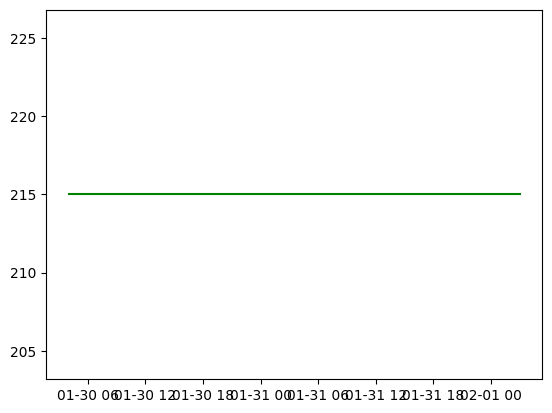

In [58]:
croston_forecast[13].plot(color='g')

TypeError: Forecast.plot() got an unexpected keyword argument 'prediction_intervals'

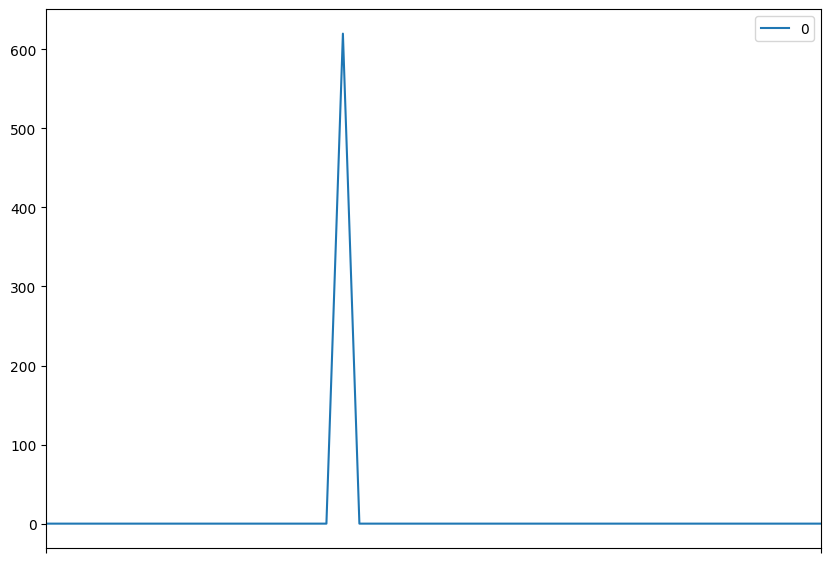

In [56]:
idx=13
plot_prob_forecasts(tss[idx], croston_forecast[idx],'croston')

In [11]:
NN_estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=prediction_length,
    context_length=7,
    trainer=Trainer(ctx="cpu", epochs=10, learning_rate=1e-3, num_batches_per_epoch=100),
)
NN_predictor = NN_estimator.train(train_dataset)

100%|██████████| 100/100 [00:00<00:00, 173.86it/s, epoch=10/10, avg_epoch_loss=-16.8]


In [12]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_dataset,  # test dataset
    predictor=NN_predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)
forecasts = list(forecast_it)
tss = list(ts_it)


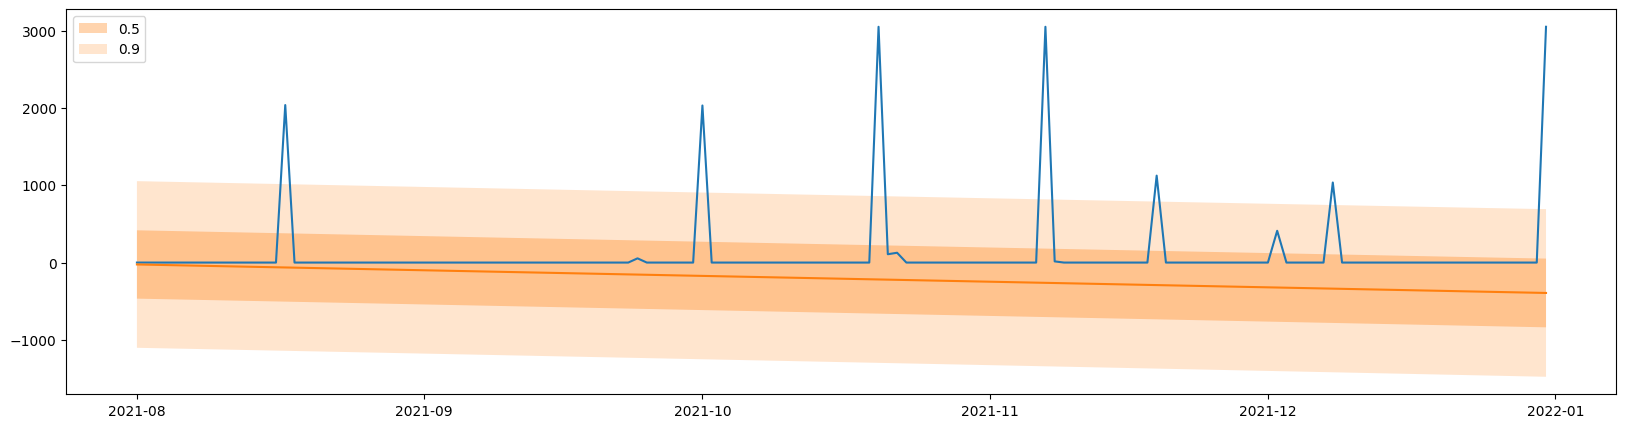

In [17]:
ts_entry = tss[109]
forecast_entry = ets_forecast[109]
plt.figure(figsize=(20,5))
plt.plot(ts_entry[-prediction_length:].to_timestamp())
forecast_entry.plot(show_label=True)
plt.legend()

In [18]:
distr = PiecewiseLinearOutput(7)

deep_ar_trainer = Trainer(
                  learning_rate=1e-2,
                  epochs=10,
                  num_batches_per_epoch=100,
                  clip_gradient=5.48481845049343,
                  weight_decay=0.001,
                  hybridize=True) #hybridize false for development

deep_ar_estimator = DeepAREstimator(
    prediction_length=prediction_length,
    context_length=prediction_length*2,
    num_layers=2,
    num_cells=128,
    cell_type='gru',
    dropout_rate=0.1,
    scaling=True,
    lags_seq=np.arange(1,1+1).tolist(),
    freq='D',
    use_feat_dynamic_real=False,
    use_feat_static_cat=False,
    use_feat_static_real=False,
    distr_output=distr,
    cardinality=None,#cardinality,
    trainer=deep_ar_trainer,
)
deep_ar_predictor = deep_ar_estimator.train(train_dataset)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:41<00:00,  1.01s/it, epoch=10/10, avg_epoch_loss=24.7]


In [19]:
deep_ar_forecast_it, ts_it = make_evaluation_predictions(
dataset=test_dataset, predictor=deep_ar_predictor, num_samples=100)
forecasts = list(deep_ar_forecast_it)
tss = list(ts_it)

Number of sample paths: 100
Dimension of samples: (100, 60)
Start date of the forecast window: 1970-01-01 00:00:00.000586130
Frequency of the time series: <Nano>
Mean of the future window:
 [-6.4786952e-12  2.3795052e-12 -3.6100201e-12 -7.5374065e-12
  1.2223915e-12 -8.2710809e-12 -5.7570016e-12  1.3524440e-12
 -3.0051198e-12 -3.5910509e-12  2.1184332e-13 -8.4625978e-12
 -2.4736552e-12  6.5300662e-13 -7.3724325e-12  1.4184849e-12
 -4.0330421e-12 -5.4235184e-12  1.0524971e-12 -3.3203410e-12
 -3.4761200e-12  3.5984375e-13 -6.1186525e-12 -5.6354331e-12
 -1.7461703e-12 -5.6360051e-12  4.5504921e-14 -4.0897663e-12
 -7.0836635e-12  1.4487633e-12 -1.1687888e-12 -6.2112273e-12
 -1.5968470e-12 -2.5396490e-12 -3.2642261e-12  7.3270350e-13
 -7.7387428e-12 -1.6741831e-12 -1.8350621e-12 -6.0190026e-12
 -1.8837009e-12 -2.7765481e-12 -6.9870841e-12 -1.5923702e-13
 -2.8717997e-13 -4.8512114e-12 -6.8938811e-13 -7.2876184e-12
 -4.1283968e-12 -1.0854825e-12 -7.7409286e-12 -2.3394429e-12
 -1.4752380e-12 -

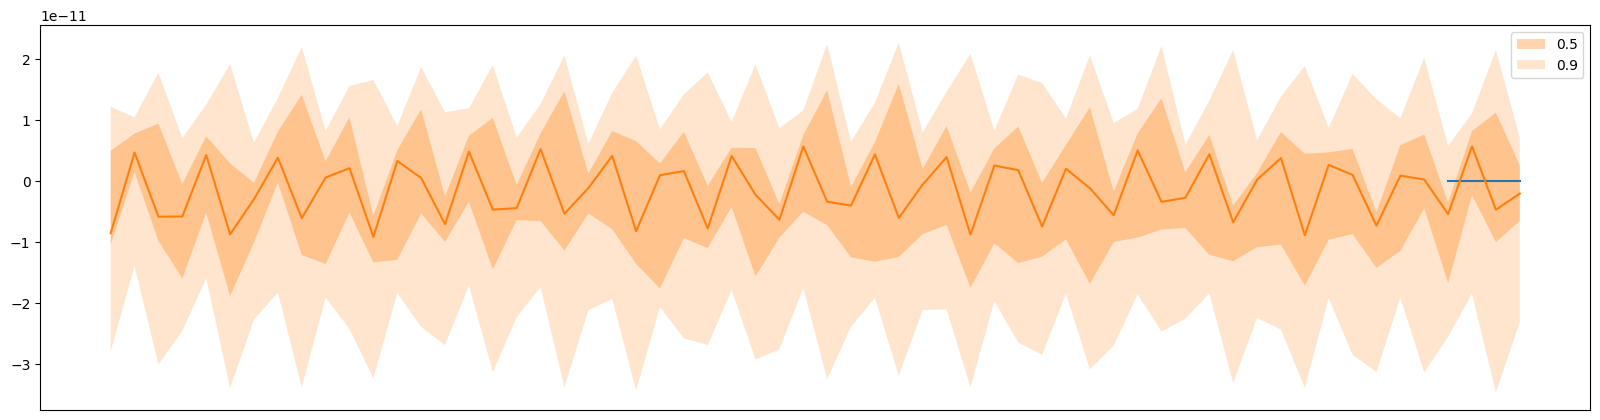

In [40]:
idx = 125
ts_entry = tss[idx]
forecast_entry = forecasts[idx]
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")
plt.figure(figsize=(20,5))
plt.plot(ts_entry[-prediction_length:].to_timestamp())
forecast_entry.plot(show_label=True)
plt.legend()

In [20]:
trainer = Trainer( 
                  learning_rate=1e-2,
                  epochs=10,
                  num_batches_per_epoch=100,
                  clip_gradient=5.17,
                  weight_decay=0.01,
                  hybridize=True) #hybridize false for development

estimator = DeepRenewalProcessEstimator(
    prediction_length=prediction_length,
    context_length=prediction_length*2,
    num_layers=2,
    num_cells=64,
    dropout_rate=0.1,
    trainer=trainer,
)
predictor = estimator.train(train_dataset)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:02<00:00, 39.74it/s, epoch=10/10, avg_epoch_loss=0]


In [1]:
drp_forecast_it, drp_ts_it = make_evaluation_predictions(
    dataset=test_dataset,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)
forecasts = list(drp_forecast_it)
tss = list(drp_ts_it)
# first entry of the time series list
ts_entry = tss[0]
# first entry of the forecast list
forecast_entry = forecasts[0]
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")
plt.figure(figsize=(20,5))
plt.plot(ts_entry.to_timestamp())
forecast_entry.plot(show_label=True)
plt.legend()

NameError: name 'make_evaluation_predictions' is not defined

In [1]:
ts_entry = tss[0]
# first entry of the forecast list
forecast_entry = forecasts[0]
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")
plt.figure(figsize=(20,5))
plt.plot(ts_entry.to_timestamp())
forecast_entry.plot(show_label=True)
plt.legend()

NameError: name 'tss' is not defined